In [ ]:
# @title Run MSAffect

# !pip freeze > requirements.txt
# !pip freeze | xargs pip uninstall -y
# !pip install -r requirements.txt

!rm -r results
!python main.py


In [ ]:
# @title Push to MSAffect GitHub

import os

GITHUB_TOKEN = ""  # @param {type: "string"}

!git add .
!git commit -m "Project update from Google Colab" || echo "nothing to commit, working tree clean"

print('Process finished with exit code', os.system(f"git push https://{GITHUB_TOKEN}@github.com/aaravdave/MSAffect.git"))

In [ ]:
# @title Initiate MSAffect Environment

!rm -r sample_data
!git clone https://github.com/aaravdave/MSAffect.git
%cd MSAffect/
!rm -r alphafold
!rm -r colabfold
!git config --global user.email "aarinaarav@gmail.com"
!git config --global user.name "Aarav Dave"

!pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"
!ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold
!ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold


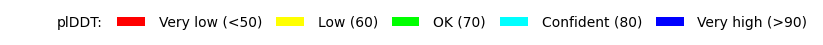

In [9]:
#@title 3D Visualize Results
import glob, py3Dmol
from pathlib import Path
from colabfold.colabfold import plot_plddt_legend
from IPython.display import HTML, display

results_root = Path("results")
proteins   = [p.name for p in results_root.iterdir() if p.is_dir()]
strategies = ["baseline","delete","mutate","shuffle"]

def make_dual_view_html(pdb_file):
    v1 = py3Dmol.view(width=200, height=200, js="https://3dmol.org/build/3Dmol.js")
    v1.addModel(open(pdb_file).read(), "pdb")
    v1.setStyle({'cartoon':{'colorscheme':{'prop':'b','gradient':'roygb','min':50,'max':90}}})
    v1.zoomTo()
    html1 = v1._make_html()

    v2 = py3Dmol.view(width=200, height=200, js="https://3dmol.org/build/3Dmol.js")
    v2.addModel(open(pdb_file).read(), "pdb")
    v2.addSurface("VDW",{'opacity':0.8,'color':'spectrum','basis':'bfactor'})
    v2.zoomTo()
    html2 = v2._make_html()

    return f"""
<div style="display:inline-block; text-align:center; margin:4px;">
  <div oncontextmenu="event.preventDefault();
                       let c=this.children[1];
                       let s=this.children[2];
                       c.style.display = c.style.display==='none'?'block':'none';
                       s.style.display = s.style.display==='none'?'block':'none';"
       style="display:inline-block; position:relative; cursor:pointer;">
    <div style="display:block">{html1}</div>
    <div style="display:none; position:absolute; top:0; left:0;">{html2}</div>
  </div>
</div>
"""

rows = []
hdr = "".join(f"<th style='padding:6px;font-size:12px'>{s.upper()}</th>" for s in strategies)
rows.append(f"<tr><th></th>{hdr}</tr>")

for prot in proteins:
    cells = [f"<th style='padding:6px;font-size:12px;text-align:left'>{prot.upper()}</th>"]
    for strat in strategies:
        pattern = str(results_root/prot/strat/"**"/"*rank_001_*.pdb")
        fns = glob.glob(pattern, recursive=True)
        if fns:
            cells.append(f"<td style='padding:4px'>{make_dual_view_html(fns[0])}</td>")
        else:
            cells.append("<td>—</td>")
    rows.append(f"<tr>{''.join(cells)}</tr>")

html_table = f"<table style='border-collapse:collapse'>{''.join(rows)}</table>"
display(HTML(html_table))

plot_plddt_legend().show()
